In [1]:
import hashlib
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

import lightgbm as lgb
from lightgbm import LGBMRegressor


In [2]:
# === 1. ЗАГРУЗКА ДАННЫХ (train) и предобработка ===
data_train = pd.read_csv('data_train_contest_Pond-1-1302.csv')


In [3]:
# Добавляем таргеты
data_train['size_usd_a'] = (data_train['total_amount_usd'] / data_train['size_a']).round(0).astype(int)
data_train['size_usd_b'] = (data_train['total_amount_usd'] / data_train['size_b']).round(0).astype(int)    
data_train['grade_Eth_usd_a'] = (data_train['total_amount_usd'] / data_train['grade_Eth_a']).round(0).astype(int)
data_train['grade_Eth_usd_b'] = (data_train['total_amount_usd'] / data_train['grade_Eth_b']).round(0).astype(int)

data_train.drop(columns=['watchers_count_a', 'watchers_count_b', 'funder'], inplace=True)


In [4]:
def hash_link(link):
    return int(hashlib.sha256(link.encode()).hexdigest(), 16) % (10**8)


In [5]:
# Заполняем пропуски и хэшируем
data_train["project_a"] = data_train["project_a"].fillna("0")
data_train["project_b"] = data_train["project_b"].fillna("0")
data_train["quarter"] = data_train["quarter"].fillna("0")
data_train["project_a_hashed"] = data_train["project_a"].apply(hash_link)
data_train["project_b_hashed"] = data_train["project_b"].apply(hash_link)
data_train["quarter_hashed"] = data_train["quarter"].apply(hash_link)


In [6]:
data_train.drop(["project_a", "project_b", "quarter"], axis=1, inplace=True)
data_train.rename(
    columns={"project_a_hashed": "project_a", "project_b_hashed": "project_b", "quarter_hashed": "quarter"},
    inplace=True
)


In [7]:
# Извлекаем признаки и таргет (target = weight_a)
predictors = data_train.drop(["weight_a", "weight_b"], axis=1)
target = data_train["weight_a"]


In [8]:
# (Необязательно) масштабируем признаки через MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(predictors)
X = pd.DataFrame(X_scaled, columns=predictors.columns)


In [9]:
# Разделяем на трейн и тест (удерживаем тестовый набор для финальной оценки)
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.2, random_state=42
)


In [10]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (16766, 49) (16766,)
Test shape: (4192, 49) (4192,)


In [11]:
# === 2. Определяем сетку гиперпараметров для GridSearchCV ===
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [15, 31, 63],
    "n_estimators": [100, 300, 500],
    # Можно добавить и другие параметры, например, max_depth, min_child_samples и т.д.
}

base_model = LGBMRegressor(
    objective="regression",  # оптимизируем MSE
    random_state=42
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,               # 3-кратная кросс-валидация
    verbose=2,
    n_jobs=-1
)


In [12]:
# === 3. Запускаем подбор гиперпараметров ===
grid_search.fit(X_train, y_train)

print("\n===== Результаты GridSearch =====")
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение метрики (отрицательный MSE):", grid_search.best_score_)

# Получаем модель с лучшими параметрами
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3426
[LightGBM] [Info] Number of data points in the train set: 16766, number of used features: 49
[LightGBM] [Info] Start training from score 0.487758

===== Результаты GridSearch =====
Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 63}
Лучшее значение метрики (отрицательный MSE): -0.011320622211009096


In [13]:
# === 4. Дополнительный этап: дообучение с использованием ранней остановки ===
# Выделяем валидационную выборку из X_train для контроля переобучения
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Перефит модели с использованием ранней остановки (early_stopping_rounds=50)
best_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],
    eval_metric="mse",
    callbacks=[lgb.early_stopping(50)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 13412, number of used features: 49
[LightGBM] [Info] Start training from score 0.487933
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.0093057


LGBMRegressor(n_estimators=500, num_leaves=63, objective='regression',
              random_state=42)

In [14]:
# === 5. Оценка модели на исходном тестовом наборе ===
y_pred_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print("Test MSE for weight_a:", mse_test)


Test MSE for weight_a: 0.009737002122173823


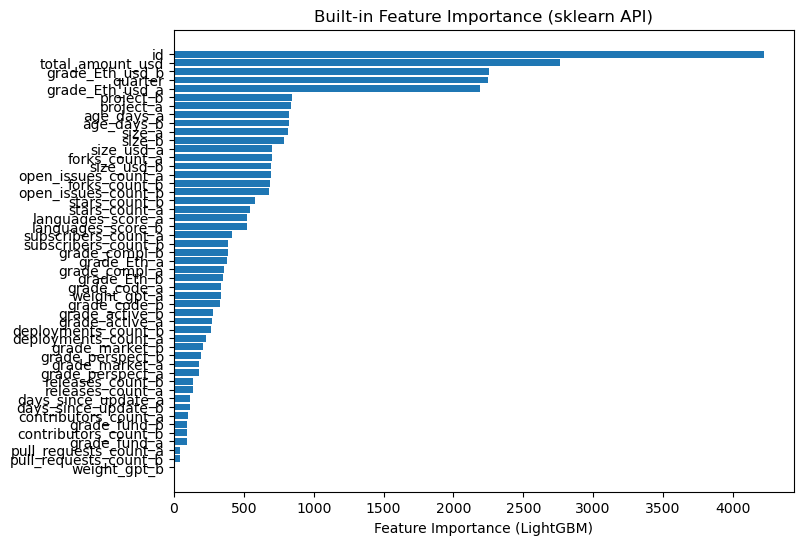

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Допустим, вы уже обучили модель так:
# best_model = grid_search.best_estimator_
# или
# best_model = LGBMRegressor(...).fit(X_train, y_train)

# 1. Достаём важности признаков
feature_importances = best_model.feature_importances_
# 2. Предположим, X — это ваш pandas DataFrame с признаками
feature_names = X.columns

# 3. Складываем в DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
})

# 4. Сортируем по важности (возрастающе, чтобы на графике от меньшего к большему)
fi_df.sort_values("importance", inplace=True)

# 5. Рисуем горизонтальный график
plt.figure(figsize=(8, 6))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.xlabel("Feature Importance (LightGBM)")
plt.title("Built-in Feature Importance (sklearn API)")
plt.show()

In [16]:
# === 6. ПРЕДСКАЗАНИЯ ДЛЯ ИТОГОВОГО ТЕСТА (для сабмита) ===
import pandas as pd
import numpy as np

In [17]:
# Загружаем тестовый набор
test_data = pd.read_csv('data_test_contest_Pond-1-1302.csv')


In [18]:
# Добавляем таргеты (аналогично обучающему набору)
test_data['size_usd_a'] = (test_data['total_amount_usd'] / test_data['size_a']).round(0).astype(int)
test_data['size_usd_b'] = (test_data['total_amount_usd'] / test_data['size_b']).round(0).astype(int)	
test_data['grade_Eth_usd_a'] = (test_data['total_amount_usd'] / test_data['grade_Eth_a']).round(0).astype(int)
test_data['grade_Eth_usd_b'] = (test_data['total_amount_usd'] / test_data['grade_Eth_b']).round(0).astype(int)


In [19]:
# Удаляем лишние столбцы
test_data.drop(columns=['watchers_count_a', 'watchers_count_b', 'funder'], inplace=True)


In [20]:
# Заполняем пропуски и хэшируем строковые признаки
test_data["project_a"] = test_data["project_a"].fillna("0")
test_data["project_b"] = test_data["project_b"].fillna("0")
test_data["quarter"] = test_data["quarter"].fillna("0")


In [21]:
# Предполагаем, что функция hash_link уже определена (см. код обучения)
test_data["project_a_hashed"] = test_data["project_a"].apply(hash_link)
test_data["project_b_hashed"] = test_data["project_b"].apply(hash_link)
test_data["quarter_hashed"] = test_data["quarter"].apply(hash_link)


In [22]:
# Удаляем исходные столбцы и переименовываем хэшированные
test_data.drop(["project_a", "project_b", "quarter"], axis=1, inplace=True)
test_data.rename(
    columns={"project_a_hashed": "project_a", "project_b_hashed": "project_b", "quarter_hashed": "quarter"},
    inplace=True
)


In [23]:
# Оставляем только те признаки, которые использовались при обучении
# Предполагаем, что predictors — исходный DataFrame признаков из обучения
features_used = predictors.columns  # predictors были определены ранее при обучении модели
X_test_final = test_data[features_used]


In [24]:
# Масштабируем признаки с использованием ранее обученного scaler
X_test_final_scaled = pd.DataFrame(scaler.transform(X_test_final), columns=features_used)


In [25]:
# Получаем предсказания для weight_a с помощью обученной модели best_model
pred_weight_a = best_model.predict(X_test_final_scaled)
pred_weight_b = 1.0 - pred_weight_a  # если требуется, можно получить weight_b как остаток


In [26]:
# Фиксируем границы предсказаний [0,1]
pred_weight_a = np.clip(pred_weight_a, 0, 1)
pred_weight_b = np.clip(pred_weight_b, 0, 1)


In [27]:
# Нормируем, чтобы сумма для каждой строки была равна 1
sum_pred = pred_weight_a + pred_weight_b
sum_pred = np.maximum(sum_pred, 1e-6)  # предотвращаем деление на 0
pred_weight_a /= sum_pred
pred_weight_b /= sum_pred


In [28]:
# Формируем итоговый DataFrame для сабмита
if "id" in test_data.columns:
    output_df = test_data[["id"]].copy()
else:
    output_df = pd.DataFrame()

output_df["weight_a_prediction"] = pred_weight_a
output_df["weight_b_prediction"] = pred_weight_b


In [29]:
# Если требуется, переименовываем столбец с weight_a_prediction в pred и удаляем второй столбец
output_df.rename(columns={"weight_a_prediction": "pred"}, inplace=True)
output_df.drop(columns=["weight_b_prediction"], inplace=True)


In [30]:
# Форматируем значения предсказаний до 11 знаков после запятой
output_df['pred'] = output_df['pred'].apply(lambda x: f"{x:.11f}")

In [31]:
output_df.head()

,id,pred
0,20884,0.08101020443
1,20885,0.05339368350
2,20886,0.33376784306
3,20887,0.96225229062
4,20888,0.20105889593


In [32]:
# Сохраняем результат в CSV-файл
output_df.to_csv("predictions_lgbm_1302-2.csv", index=False)
print("Предсказания сохранены в 'predictions_lgbm_1302-2.csv'.")

Предсказания сохранены в 'predictions_lgbm_1302-2.csv'.
